In [ ]:
! pip install -q kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=e8dbf96e682cfce6ce384d959eb986e0b6b9c3c16e6b3aea7fb330053e716615
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download histopathologic-cancer-detection

100% 6.30G/6.31G [02:10<00:00, 34.5MB/s]
100% 6.31G/6.31G [02:10<00:00, 52.0MB/s]


In [ ]:
! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import cv2
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import zipfile 

In [3]:
current_path = '/content/'
train_path = current_path + 'train_labels.csv'

train_dir = current_path + 'train/'
test_dir = current_path + 'test/'

# load the training data
train = pd.read_csv(train_path, dtype='str')
# make the label value integer
train['label'] = train['label'].astype('uint8')

# add the images extensions
train['id'] = train['id']+ '.tif'
print(len(train))
train.head(5)

220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The image shape:  (96, 96, 3)


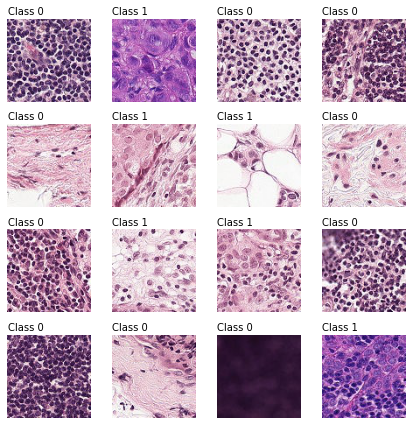

In [4]:
# view sample data
sample = train.sample(n=16).reset_index()
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i, row in sample.iterrows():  
    # a (96, 96, 3) image shape
    img = mpimg.imread(f'{train_dir}{row.id}')
    label = row.label
    plt.subplot(4,4,i+1)    # the number of images in the grid is 6*6 (16)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')

print('The image shape: ', img.shape)
plt.tight_layout()
plt.show()

In [5]:
# display the count of the two classes
print('1 classes: ', len(train[train['label'] == 1]))
print('0 classes: ', len(train[train['label'] == 0]))

# so the data is biased to the 0 class
# make a balance between these two classes
sample_size = 5000

train_0 = train[train['label'] == 0].sample(sample_size, random_state=1)
train_1 = train[train['label'] == 1].sample(sample_size, random_state=1)

# now lets merge the two classes again into the same training set
train_set = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

# shuffle the data
train = shuffle(train_set)

train['label'].value_counts()

1 classes:  89117
0 classes:  130908


1    5000
0    5000
Name: label, dtype: int64

In [6]:
# read the training data
train_df = []
labels_df = []

for _, img_path, label in train.itertuples():
    image = cv2.imread(train_dir + img_path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    train_df.append(image)
    labels_df.append(label)

train_df = np.array(train_df)
labels_df = np.array(labels_df)

print(type(train_df))
print(type(labels_df))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df,
    labels_df,
    test_size=0.2,
    random_state=1
)

# normalize the images
X_train, X_test = X_train / 255.0, X_test / 255.0

In [8]:
# define the feature extractor net
activation = 'sigmoid'
SIZE = 96

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

# feature_extractor.add(Dense(128, activation='relu'))
# feature_extractor.add(Dropout(0.25))
# feature_extractor.add(Dense(64, activation='relu'))
# feature_extractor.add(Dropout(0.25))
# feature_extractor.add(Dense(8, activation='softmax'))

feature_extractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                        

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rnd_clf = RandomForestClassifier(n_estimators = 50, random_state = 42)

# get features for the training data
X_train_rnd = feature_extractor.predict(X_train)

# Train the model on training data
rnd_clf.fit(X_train_rnd, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_rnd = feature_extractor.predict(X_test)

#Now predict using the trained RF model. 
prediction_RF = rnd_clf.predict(X_test_rnd)


#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))


Accuracy =  0.789


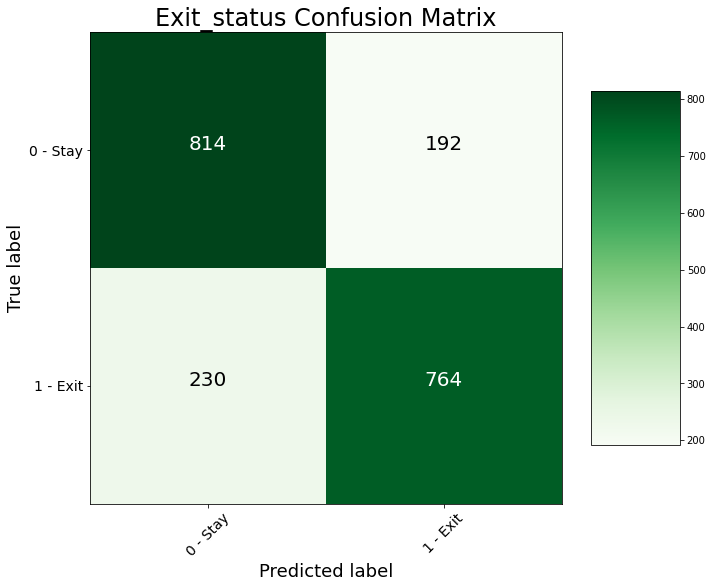

In [14]:
import itertools

def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

# Let's plot it out
cm = metrics.confusion_matrix(y_test, prediction_RF)
plot_confusion_matrix(cm, classes = ['0 - Stay', '1 - Exit'],
                      title = 'Exit_status Confusion Matrix')
